# MODEL 3 Original 3 # 2
### Contains only fixed-before-conditional trials without intervening BLs
### Combines A & C trials into single regressor
### Accounts for last three noisy volumes in Lvl 1 analysis (FSL ROI -- ExtractROI)

## Compares activation for regions of interest using binarized masks:
### Hippocampus (FS labels: hippocampus [17, 53])
### Dorsal caudate (hand-drawn by Mandy)
### Putamen (FS labels: putamen [12, 51])

In [2]:
import os
from glob import glob

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/data/mri/wmaze'
 
mask_filenames = []
cope_files = []

for SID in sids:
    mask_filenames_glob = glob(proj_dir + '/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_' 
                               + SID + '/_anatmask_xfm*/*')
    mask_filenames.append(mask_filenames_glob)

    subjcopes_glob = glob(proj_dir + '/scndlvl/wmaze_MRthesis/fixed_before_conditional/model3_1-3-2/' 
                          + SID + '/fixedfx/cope_*')
    cope_files.append(subjcopes_glob)
    if len(cope_files[-1]) == 0:
        print(SID)

## Cell to double-check the array indexing

In [4]:
print 'left hippocampus'
print(mask_filenames[0][0]) #lh-hippocampus
print 'left caudate'
print(mask_filenames[0][1]) #lh-caudate
print 'right caudate'
print(mask_filenames[0][2]) #rh-caudate
print 'right hippocampus'
print(mask_filenames[0][3]) #rh-hippocamus
print 'left putamen'
print(mask_filenames[0][4]) #lh-putamen
print 'right putamen'
print(mask_filenames[0][5]) #rh-putamen

print '-----'

print 'all_before_B_corr'
print(cope_files[0][0]) #A_before_B_corr
print 'all_before_B_incorr'
print(cope_files[0][1]) #A_before_B_incorr
print 'all_remaining'
print(cope_files[0][2]) #C_before_B_corr
print 'all_corr_vs_all_incorr'
print(cope_files[0][3]) #C_before_B_incorr
print 'all_incorr_vs_all_corr'
print(cope_files[0][4]) #all_A_and_C



#for i in cope_files:
#    print(len(i))

left hippocampus
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-hippocampus_warped.nii.gz
left caudate
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh_caudate_anat_mask_warped.nii.gz
right caudate
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/rh_caudate_anat_mask_warped.nii.gz
right hippocampus
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm1/rh-hippocampus_warped.nii.gz
left putamen
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm2/lh-putamen_warped.nii.gz
right putamen
/home/data/madlab/data/mri/wmaze/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm3/rh-putamen_warped.nii.gz
-----
all_before_B_corr
/home/data/madlab/d

### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [2]:
import nibabel as nb
import pandas as pd
import numpy as np


#Dictionary containing multiple arrays referenced by keywords
all_data = {'subjid':[],
            'lhhp_all_before_B_corr':[], 'rhhp_all_before_B_corr':[], 
            'lhhp_all_before_B_incorr':[], 'rhhp_all_before_B_incorr':[],
            'lhhp_all_remaining':[], 'rhhp_all_remaining':[],
            'lhhp_all_corr_vs_all_incorr':[], 'rhhp_all_corr_vs_all_incorr':[], 
            'lhhp_all_incorr_vs_all_corr':[], 'rhhp_all_incorr_vs_all_corr':[],
            
            'lhcaudate_all_before_B_corr':[], 'rhcaudate_all_before_B_corr':[], 
            'lhcaudate_all_before_B_incorr':[], 'rhcaudate_all_before_B_incorr':[],
            'lhcaudate_all_remaining':[], 'rhcaudate_all_remaining':[],
            'lhcaudate_all_corr_vs_all_incorr':[], 'rhcaudate_all_corr_vs_all_incorr':[], 
            'lhcaudate_all_incorr_vs_all_corr':[], 'rhcaudate_all_incorr_vs_all_corr':[],
            
            'lhputamen_all_before_B_corr':[], 'rhputamen_all_before_B_corr':[], 
            'lhputamen_all_before_B_incorr':[], 'rhputamen_all_before_B_incorr':[],
            'lhputamen_all_remaining':[], 'rhputamen_all_remaining':[],
            'lhputamen_all_corr_vs_all_incorr':[], 'rhputamen_all_corr_vs_all_incorr':[], 
            'lhputamen_all_incorr_vs_all_corr':[], 'rhputamen_all_incorr_vs_all_corr':[]}


# For each interation in the length of subject ids
for i in range(len(sids)):
    #Append the subject id
    all_data['subjid'].append(sids[i])
    #Load the left and right hippocampus mask files using Nibabel 
    lh_hp_img = nb.load(mask_filenames[i][0])
    rh_hp_img = nb.load(mask_filenames[i][3])
    lh_caudate_img = nb.load(mask_filenames[i][1])
    rh_caudate_img = nb.load(mask_filenames[i][2])
    lh_putamen_img = nb.load(mask_filenames[i][4])
    rh_putamen_img = nb.load(mask_filenames[i][5])

    
    #Load copes for individual trial types
    all_before_B_corr_img = nb.load(cope_files[i][0])
    all_before_B_incorr_img = nb.load(cope_files[i][1])
    all_remaining_img = nb.load(cope_files[i][2])
    all_corr_vs_all_incorr_img = nb.load(cope_files[i][3])
    all_incorr_vs_all_corr_img = nb.load(cope_files[i][4])

    
    
    ########################
    ### Left Hippocampus ###
    ########################
    
    # all_before_B_corr
    lh_hp_all_before_B_corr_data = all_before_B_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_all_before_B_corr'].append(np.mean(lh_hp_all_before_B_corr_data))
    
    # all_before_B_incorr
    lh_hp_all_before_B_incorr_data = all_before_B_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_all_before_B_incorr'].append(np.mean(lh_hp_all_before_B_incorr_data))
    
    # all_remaining
    lh_hp_all_remaining_data = all_remaining_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_all_remaining'].append(np.mean(lh_hp_all_remaining_data))
       
    # all_corr_vs_all_incorr
    lh_hp_all_corr_vs_all_incorr_data = all_corr_vs_all_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_all_corr_vs_all_incorr'].append(np.mean(lh_hp_all_corr_vs_all_incorr_data)) 
    
    # all_incorr_vs_all_corr
    lh_hp_all_incorr_vs_all_corr_data = all_incorr_vs_all_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lhhp_all_incorr_vs_all_corr'].append(np.mean(lh_hp_all_incorr_vs_all_corr_data)) 

    
    #########################
    ### Right Hippocampus ###
    #########################
    
    # all_before_B_corr
    rh_hp_all_before_B_corr_data = all_before_B_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_all_before_B_corr'].append(np.mean(rh_hp_all_before_B_corr_data))

    # all_before_B_incorr
    rh_hp_all_before_B_incorr_data = all_before_B_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_all_before_B_incorr'].append(np.mean(rh_hp_all_before_B_incorr_data))

    # all_remaining
    rh_hp_all_remaining_data = all_remaining_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_all_remaining'].append(np.mean(rh_hp_all_remaining_data))

    # all_corr_vs_all_incorr
    rh_hp_all_corr_vs_all_incorr_data = all_corr_vs_all_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_all_corr_vs_all_incorr'].append(np.mean(rh_hp_all_corr_vs_all_incorr_data)) 

    # all_incorr_vs_all_corr
    rh_hp_all_incorr_vs_all_corr_data = all_incorr_vs_all_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rhhp_all_incorr_vs_all_corr'].append(np.mean(rh_hp_all_incorr_vs_all_corr_data)) 

    
    ####################
    ### Left Caudate ###
    ####################
    
    # all_before_B_corr
    lh_caudate_all_before_B_corr_data = all_before_B_corr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_all_before_B_corr'].append(np.mean(lh_caudate_all_before_B_corr_data))
    
    # all_before_B_incorr
    lh_caudate_all_before_B_incorr_data = all_before_B_incorr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_all_before_B_incorr'].append(np.mean(lh_caudate_all_before_B_incorr_data))
    
    # all_remaining
    lh_caudate_all_remaining_data = all_remaining_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_all_remaining'].append(np.mean(lh_caudate_all_remaining_data))
       
    # all_corr_vs_all_incorr
    lh_caudate_all_corr_vs_all_incorr_data = all_corr_vs_all_incorr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_all_corr_vs_all_incorr'].append(np.mean(lh_caudate_all_corr_vs_all_incorr_data)) 
    
    # all_incorr_vs_all_corr
    lh_caudate_all_incorr_vs_all_corr_data = all_incorr_vs_all_corr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lhcaudate_all_incorr_vs_all_corr'].append(np.mean(lh_caudate_all_incorr_vs_all_corr_data)) 
    
    
    #####################
    ### Right Caudate ###
    ##################### 
    
    # all_before_B_corr
    rh_caudate_all_before_B_corr_data = all_before_B_corr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_all_before_B_corr'].append(np.mean(rh_caudate_all_before_B_corr_data))

    # all_before_B_incorr
    rh_caudate_all_before_B_incorr_data = all_before_B_incorr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_all_before_B_incorr'].append(np.mean(rh_caudate_all_before_B_incorr_data))

    # all_remaining
    rh_caudate_all_remaining_data = all_remaining_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_all_remaining'].append(np.mean(rh_caudate_all_remaining_data))

    # all_corr_vs_all_incorr
    rh_caudate_all_corr_vs_all_incorr_data = all_corr_vs_all_incorr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_all_corr_vs_all_incorr'].append(np.mean(rh_caudate_all_corr_vs_all_incorr_data)) 

    # all_incorr_vs_all_corr
    rh_caudate_all_incorr_vs_all_corr_data = all_incorr_vs_all_corr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rhcaudate_all_incorr_vs_all_corr'].append(np.mean(rh_caudate_all_incorr_vs_all_corr_data)) 
    
    
    ####################
    ### Left Putamen ###
    ####################
    
    # all_before_B_corr
    lh_putamen_all_before_B_corr_data = all_before_B_corr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_all_before_B_corr'].append(np.mean(lh_putamen_all_before_B_corr_data))
    
    # all_before_B_incorr
    lh_putamen_all_before_B_incorr_data = all_before_B_incorr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_all_before_B_incorr'].append(np.mean(lh_putamen_all_before_B_incorr_data))
    
    # all_remaining
    lh_putamen_all_remaining_data = all_remaining_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_all_remaining'].append(np.mean(lh_putamen_all_remaining_data))
       
    # all_corr_vs_all_incorr
    lh_putamen_all_corr_vs_all_incorr_data = all_corr_vs_all_incorr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_all_corr_vs_all_incorr'].append(np.mean(lh_putamen_all_corr_vs_all_incorr_data)) 
    
    # all_incorr_vs_all_corr
    lh_putamen_all_incorr_vs_all_corr_data = all_incorr_vs_all_corr_img.get_data()[lh_putamen_img.get_data() > 0.]
    all_data['lhputamen_all_incorr_vs_all_corr'].append(np.mean(lh_putamen_all_incorr_vs_all_corr_data)) 
    
    
    #####################
    ### Right Putamen ###
    #####################
    
    # all_before_B_corr
    rh_putamen_all_before_B_corr_data = all_before_B_corr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_all_before_B_corr'].append(np.mean(rh_putamen_all_before_B_corr_data))

    # all_before_B_incorr
    rh_putamen_all_before_B_incorr_data = all_before_B_incorr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_all_before_B_incorr'].append(np.mean(rh_putamen_all_before_B_incorr_data))

    # all_remaining
    rh_putamen_all_remaining_data = all_remaining_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_all_remaining'].append(np.mean(rh_putamen_all_remaining_data))

    # all_corr_vs_all_incorr
    rh_putamen_all_corr_vs_all_incorr_data = all_corr_vs_all_incorr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_all_corr_vs_all_incorr'].append(np.mean(rh_putamen_all_corr_vs_all_incorr_data)) 

    # all_incorr_vs_all_corr
    rh_putamen_all_incorr_vs_all_corr_data = all_incorr_vs_all_corr_img.get_data()[rh_putamen_img.get_data() > 0.]
    all_data['rhputamen_all_incorr_vs_all_corr'].append(np.mean(rh_putamen_all_incorr_vs_all_corr_data)) 

    
all_data_df = pd.DataFrame(all_data)

### Combine the two hemispheres to create one regional average

In [3]:
#Hippocampus average for each trial type
all_data_df['hp_all_before_B_corr'] = (all_data_df['lhhp_all_before_B_corr'] + 
                                       all_data_df['rhhp_all_before_B_corr'])/2.
all_data_df['hp_all_before_B_incorr'] = (all_data_df['lhhp_all_before_B_incorr'] + 
                                         all_data_df['rhhp_all_before_B_incorr'])/2.
all_data_df['hp_all_remaining'] = (all_data_df['lhhp_all_remaining'] + 
                                   all_data_df['rhhp_all_remaining'])/2.
all_data_df['hp_all_corr_vs_all_incorr'] = (all_data_df['lhhp_all_corr_vs_all_incorr'] + 
                                            all_data_df['rhhp_all_corr_vs_all_incorr'])/2.
all_data_df['hp_all_incorr_vs_all_corr'] = (all_data_df['lhhp_all_incorr_vs_all_corr'] + 
                                            all_data_df['rhhp_all_incorr_vs_all_corr'])/2.


#Caudate average for each trial type
all_data_df['caudate_all_before_B_corr'] = (all_data_df['lhcaudate_all_before_B_corr'] + 
                                            all_data_df['rhcaudate_all_before_B_corr'])/2.
all_data_df['caudate_all_before_B_incorr'] = (all_data_df['lhcaudate_all_before_B_incorr'] + 
                                              all_data_df['rhcaudate_all_before_B_incorr'])/2.
all_data_df['caudate_all_remaining'] = (all_data_df['lhcaudate_all_remaining'] + 
                                        all_data_df['rhcaudate_all_remaining'])/2.
all_data_df['caudate_all_corr_vs_all_incorr'] = (all_data_df['lhcaudate_all_corr_vs_all_incorr'] + 
                                                 all_data_df['rhcaudate_all_corr_vs_all_incorr'])/2.
all_data_df['caudate_all_incorr_vs_all_corr'] = (all_data_df['lhcaudate_all_incorr_vs_all_corr'] + 
                                                 all_data_df['rhcaudate_all_incorr_vs_all_corr'])/2.


#Putamen average for each trial type
all_data_df['putamen_all_before_B_corr'] = (all_data_df['lhputamen_all_before_B_corr'] + 
                                            all_data_df['rhputamen_all_before_B_corr'])/2.
all_data_df['putamen_all_before_B_incorr'] = (all_data_df['lhputamen_all_before_B_incorr'] + 
                                              all_data_df['rhputamen_all_before_B_incorr'])/2.
all_data_df['putamen_all_remaining'] = (all_data_df['lhputamen_all_remaining'] + 
                                        all_data_df['rhputamen_all_remaining'])/2.
all_data_df['putamen_all_corr_vs_all_incorr'] = (all_data_df['lhputamen_all_corr_vs_all_incorr'] + 
                                                 all_data_df['rhputamen_all_corr_vs_all_incorr'])/2.
all_data_df['putamen_all_incorr_vs_all_corr'] = (all_data_df['lhputamen_all_incorr_vs_all_corr'] + 
                                                 all_data_df['rhputamen_all_incorr_vs_all_corr'])/2.

## Hippocampus Activation: Fixed before correct vs. incorrect conditional trials

In [4]:
from scipy import stats

print 'all_before_B_corr mean'
print all_data_df['hp_all_before_B_corr'].mean()
print 'all_before_B_incorr'
print all_data_df['hp_all_before_B_incorr'].mean()


print 'T-test: Hippocampus all_before_B_corr vs. all_before_B_incorr'
print stats.ttest_rel(all_data_df['hp_all_before_B_corr'], all_data_df['hp_all_before_B_incorr'])


all_before_B_corr mean
-1.30885470174
all_before_B_incorr
-2.4400381187
T-test: Hippocampus all_before_B_corr vs. all_before_B_incorr
Ttest_relResult(statistic=4.0552400236334325, pvalue=0.00067536878486218607)


### Hippocampus Activation: All Before Correct vs. Incorrect Trials

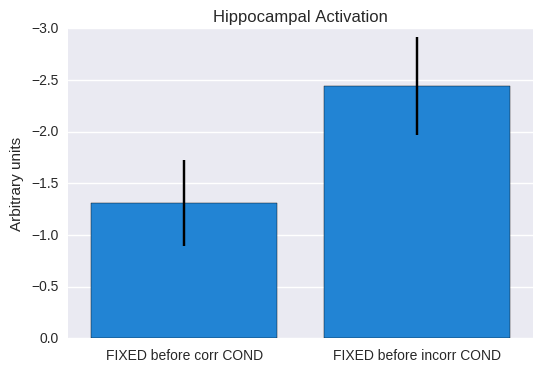

In [59]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('muted')
sns.set_style("darkgrid")

N = 2
conditions = ['FIXED before corr COND', 'FIXED before incorr COND']
hp_means_allsubjs = [all_data_df['hp_all_before_B_corr'].mean(), 
                     all_data_df['hp_all_before_B_incorr'].mean()]
hp_sem_allsubjs = [all_data_df['hp_all_before_B_corr'].std()/(np.sqrt(len(sids))), 
                   all_data_df['hp_all_before_B_incorr'].std()/(np.sqrt(len(sids)))]

ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax = sns.barplot(ind, hp_means_allsubjs, yerr = hp_sem_allsubjs, 
                color = "#0487f2", ecolor = 'black')

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_ylim(0,-3)
#ax.set_xlabel("Trial Type")
ax.set_title("Hippocampal Activation")

plt.show()

### Caudate Stats

In [7]:
from scipy import stats

print 'all_before_B_corr'
print all_data_df['caudate_all_before_B_corr'].mean()
print 'all_before_B_incorr'
print all_data_df['caudate_all_before_B_incorr'].mean()


print 'T-test: Caudate all_before_B_corr vs. all_before_B_incorr'
print stats.ttest_rel(all_data_df['caudate_all_before_B_corr'], all_data_df['caudate_all_before_B_incorr'])

all_before_B_corr
0.842863067612
all_before_B_incorr
1.32298891358
T-test: Caudate all_before_B_corr vs. all_before_B_incorr
Ttest_relResult(statistic=-1.5067181720815932, pvalue=0.14832917492269207)


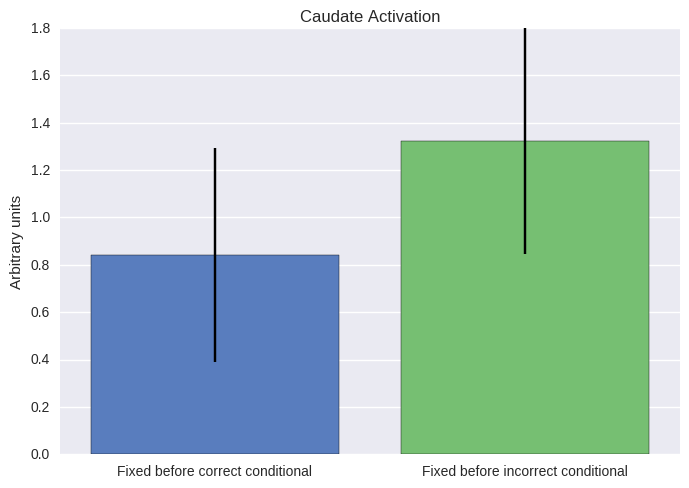

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('muted')
sns.set_style("darkgrid")

N = 2
conditions = ['Fixed before correct conditional', 'Fixed before incorrect conditional']
bar_colors = ['blue']
caudate_means_allsubjs = [all_data_df['caudate_all_before_B_corr'].mean(), 
                          all_data_df['caudate_all_before_B_incorr'].mean()]
caudate_sem_allsubjs = [stats.sem(all_data_df['caudate_all_before_B_corr']), 
                        stats.sem(all_data_df['caudate_all_before_B_incorr'])]

ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax = sns.barplot(ind, caudate_means_allsubjs, yerr = caudate_sem_allsubjs, ecolor = 'black')

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
#ax.set_xlabel("Trial Type")
ax.set_title("Caudate Activation")

plt.show()

### Putamen Stats

In [9]:
from scipy import stats

print 'all_before_B_corr'
print all_data_df['putamen_all_before_B_corr'].mean()
print 'all_before_B_incorr'
print all_data_df['putamen_all_before_B_incorr'].mean()


print 'T-test: putamen all_before_B_corr vs. all_before_B_incorr'
print stats.ttest_rel(all_data_df['putamen_all_before_B_corr'], all_data_df['putamen_all_before_B_incorr'])

all_before_B_corr
0.733108835854
all_before_B_incorr
-0.481846473366
T-test: putamen all_before_B_corr vs. all_before_B_incorr
Ttest_relResult(statistic=3.4841295178852945, pvalue=0.0024831668189734114)


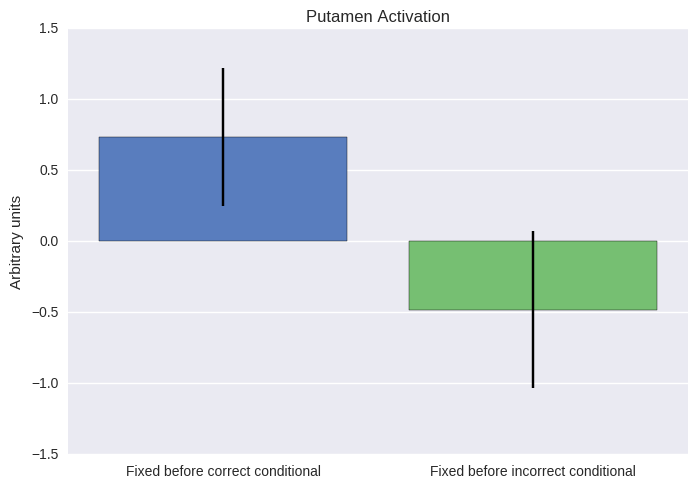

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('muted')
sns.set_style("darkgrid")

N = 2
conditions = ['Fixed before correct conditional', 'Fixed before incorrect conditional']
putamen_means_allsubjs = [all_data_df['putamen_all_before_B_corr'].mean(), 
                          all_data_df['putamen_all_before_B_incorr'].mean()]
putamen_sem_allsubjs = [stats.sem(all_data_df['putamen_all_before_B_corr']), #.std()/(np.sqrt(len(sids))), 
                        stats.sem(all_data_df['putamen_all_before_B_incorr'])] #.std()/(np.sqrt(len(sids)))]

ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax = sns.barplot(ind, putamen_means_allsubjs, yerr = putamen_sem_allsubjs, ecolor = 'black')

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("Putamen Activation")

plt.show()

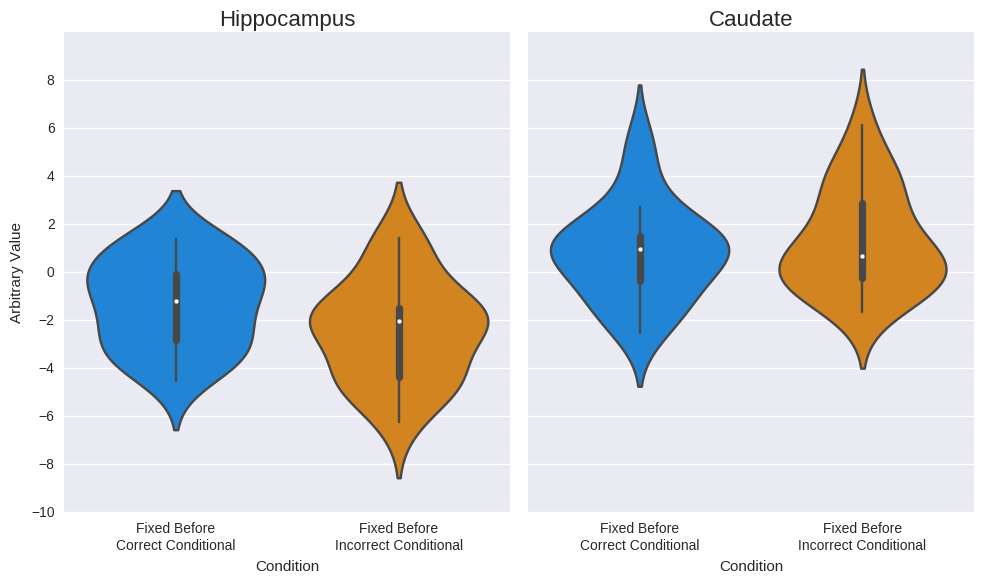

In [6]:
#violin plot -- Huntington Beach 2018

cols = [['hp_all_before_B_corr', 'hp_all_before_B_incorr'],
        ['caudate_all_before_B_corr', 'caudate_all_before_B_incorr']]
rois = ['Hippocampus', 'Caudate']

fig, axes = plt.subplots(ncols=2, figsize=(1, 6), sharey=True)

for i, roi in enumerate(rois):
    pal = ["#0487f2", "#ef8801"]
    pal = sns.color_palette(pal)
    temp_df = all_data_df[cols[i]]
    temp_df = temp_df.rename(columns={cols[i][0]: 'Fixed Before\nCorrect Conditional',
                                      cols[i][1]: 'Fixed Before\nIncorrect Conditional'})
    temp_df['subject'] = temp_df.index
    temp_df = pd.melt(temp_df, id_vars='subject',
                      value_vars=['Fixed Before\nCorrect Conditional',
                                  'Fixed Before\nIncorrect Conditional'],
                      value_name='Arbitrary Value', var_name='Condition')
    sns.violinplot(data=temp_df, x='Condition', y='Arbitrary Value', ax=axes[i], palette=pal)
    axes[i].set_yticks(np.arange(-10,10,step=2))
    axes[i].set_title(roi, fontsize=16)
    axes[i].set_ylim((-10, 10))
axes[1].set_ylabel('')
plt.tight_layout()
plt.show()


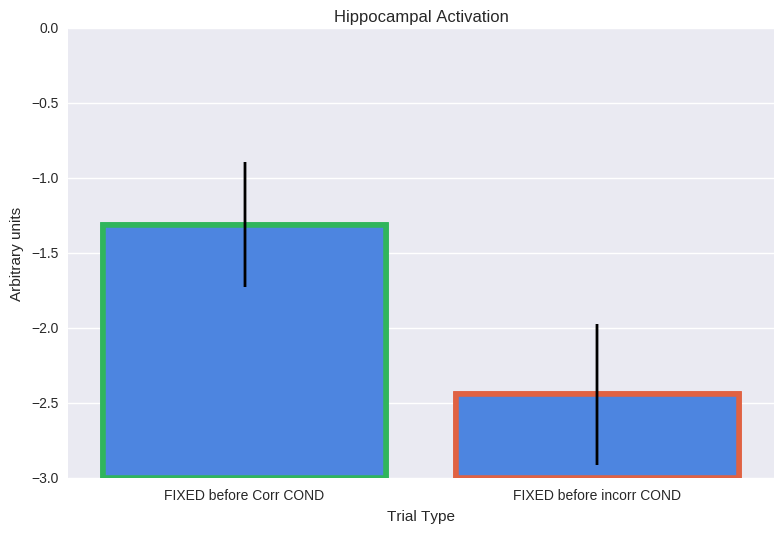

In [7]:
#hippocampus figure -- Huntington Beach 2018

conditions = ['FIXED before Corr COND', 'FIXED before incorr COND']

hp_means_allsubjs = [np.mean(all_data_df['hp_all_before_B_corr']), 
                     np.mean(all_data_df['hp_all_before_B_incorr'])]
hp_sem_allsubjs = [stats.sem(all_data_df['hp_all_before_B_corr']), 
                   stats.sem(all_data_df['hp_all_before_B_incorr'])]

fig, ax = plt.subplots()
pal = ["#30b55c", "#e06243"]
pal = sns.color_palette(pal) 
      
sns.barplot(ind, np.array(hp_means_allsubjs)+3, yerr = hp_sem_allsubjs, 
            color = "#347ff9", ecolor = 'black', edgecolor = pal, linewidth = 4, bottom = -3)

ax.set_xticklabels(conditions)
ax.set_ylabel('')
ax.set_ylim(-3,0)
ax.set_xlabel("Trial Type")
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampal Activation")
plt.tight_layout()
plt.savefig("/home/data/madlab/scripts/wmaze/anal_MR_thesis/fixed_before_conditional/model3/chpc_activation.jpg")
plt.show()

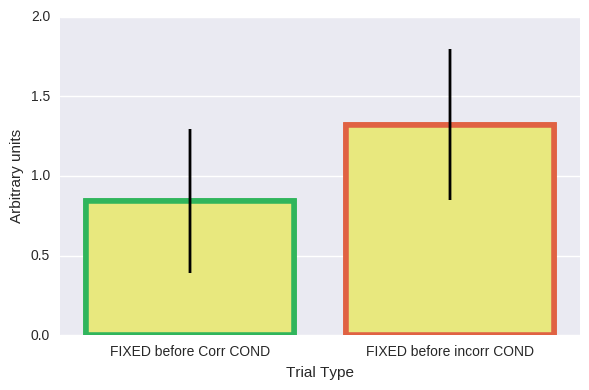

In [113]:
#caudate figure -- Huntington Beach 2018

conditions = ['FIXED before Corr COND', 'FIXED before incorr COND']

caudate_means_allsubjs = [np.mean(all_data_df['caudate_all_before_B_corr']), 
                          np.mean(all_data_df['caudate_all_before_B_incorr'])]
caudate_sem_allsubjs = [stats.sem(all_data_df['caudate_all_before_B_corr']), 
                        stats.sem(all_data_df['caudate_all_before_B_incorr'])]

fig, ax = plt.subplots()

pal = ["#30b55c", "#e06243"]
pal = sns.color_palette(pal)

sns.barplot(ind, caudate_means_allsubjs, yerr = caudate_sem_allsubjs, 
            color = "#f9f96d", ecolor = 'black', edgecolor = pal, linewidth = 4)

ax.set_xticklabels(conditions)
ax.set_ylabel('')
ax.set_ylim(0,2)
ax.set_xlabel("Trial Type")
ax.set_ylabel("Arbitrary units")
plt.tight_layout()
plt.savefig("/home/data/madlab/scripts/wmaze/anal_MR_thesis/fixed_before_conditional/model3/caudate_activation.jpg")
plt.show()